In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import logging

import pandas as pd

import core.config as cconfig
import core.finance as cofinanc
import core.plotting as coplotti
import dataflow.core as dtfcore
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import im_v2.common.data.client as icdc
import im_v2.common.universe as ivcu

/app/amp/core/signal_processing/decorrelation.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-2b19ddc3-a193-482c-9ffe-1186bbc45776.json'
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.4.2' != container_version='1.4.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CmTask4624_perfom_EDA_on_universe_7_5'
  hash='cf428e89a'
  # Last commits:
    *   cf428e89a Nina Lee Merge branch 'master' into CmTask4624_perfom_EDA_on_universe_7_5  (66 minutes ago) Fri Jun 30 11:59:21 2023  (HEAD -> CmTask4624_perfom_EDA_on_universe_7_5, origin/CmTask4624_perfom_EDA_on_universe_7_5)
    |\  
    | * d002177dc Nina Lee CmTask4672_slow_tests_fail (#4675)                                (   2 hours ago) Fri

# Config

In [4]:
config = {
    "reader": {
        "signature": "bulk.airflow.downloaded_1min.parquet.ohlcv.futures.v7_5.ccxt.binance.v1_0_0",
        "start_timestamp": None,
        # TODO(Grisha): for some reason `RawDataReader` does not work with both timestamps being None.
        "end_timestamp": pd.Timestamp("2023-06-30"),
    },
    "column_names": {
        "timestamp": "timestamp",
        "asset_id_col": "full_symbol",
        "open": "open",
        "low": "low",
        "high": "high",
        "close": "close",
        "volume": "volume",
        "volume_notional": "volume_notional",
    },
    "resampling_rule": "D",
}
config = cconfig.Config().from_dict(config)
print(config)

reader: 
  signature: bulk.airflow.downloaded_1min.parquet.ohlcv.futures.v7_5.ccxt.binance.v1_0_0
  start_timestamp: None
  end_timestamp: 2023-06-30 00:00:00
column_names: 
  timestamp: timestamp
  asset_id_col: full_symbol
  open: open
  low: low
  high: high
  close: close
  volume: volume
  volume_notional: volume_notional
resampling_rule: D


# Load and post-process OHLCV data

In [11]:
# TODO(Grisha): use MarketData, see CmTask4713 "Propagate download_universe_version
# to ImClient".
reader = icdc.RawDataReader(config["reader"]["signature"], stage="test")
ohlcv_data = reader.read_data(
    config["reader"]["start_timestamp"], config["reader"]["end_timestamp"]
)
_LOG.info("df.shape=%s", ohlcv_data.shape)
ohlcv_data.head(3)

INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  df.shape=(19758240, 11)


,timestamp,open,high,low,close,volume,exchange_id,knowledge_timestamp,currency_pair,year,month
timestamp,,,,,,,,,,,
2023-02-01 00:00:00+00:00,1675209600000,0.5141,0.5143,0.5137,0.5142,59009.0,binance,2023-06-20 17:19:02.877891+00:00,1INCH_USDT,2023,2
2023-02-01 00:01:00+00:00,1675209660000,0.5142,0.5143,0.5140,0.5140,26966.0,binance,2023-06-20 17:19:02.877891+00:00,1INCH_USDT,2023,2
2023-02-01 00:02:00+00:00,1675209720000,0.5141,0.5157,0.5141,0.5154,49452.0,binance,2023-06-20 17:19:02.877891+00:00,1INCH_USDT,2023,2


In [12]:
# Add full symbol column to df.
full_symbol_col = ivcu.build_full_symbol(
    ohlcv_data["exchange_id"], ohlcv_data["currency_pair"]
)
ohlcv_data.insert(0, config["column_names"]["asset_id_col"], full_symbol_col)
ohlcv_data.head(3)

,full_symbol,timestamp,open,high,low,close,volume,exchange_id,knowledge_timestamp,currency_pair,year,month
timestamp,,,,,,,,,,,,
2023-02-01 00:00:00+00:00,binance::1INCH_USDT,1675209600000,0.5141,0.5143,0.5137,0.5142,59009.0,binance,2023-06-20 17:19:02.877891+00:00,1INCH_USDT,2023,2
2023-02-01 00:01:00+00:00,binance::1INCH_USDT,1675209660000,0.5142,0.5143,0.5140,0.5140,26966.0,binance,2023-06-20 17:19:02.877891+00:00,1INCH_USDT,2023,2
2023-02-01 00:02:00+00:00,binance::1INCH_USDT,1675209720000,0.5141,0.5157,0.5141,0.5154,49452.0,binance,2023-06-20 17:19:02.877891+00:00,1INCH_USDT,2023,2


In [13]:
# Remove `timestamp` column since the info is already in index.
ohlcv_data = ohlcv_data.drop(config["column_names"]["timestamp"], axis=1)
ohlcv_data = (
    ohlcv_data.reset_index()
    .sort_values(
        [
            config["column_names"]["asset_id_col"],
            config["column_names"]["timestamp"],
        ]
    )
    .set_index("timestamp")
)
ohlcv_data.head(3)

,full_symbol,open,high,low,close,volume,exchange_id,knowledge_timestamp,currency_pair,year,month
timestamp,,,,,,,,,,,
2023-02-01 00:00:00+00:00,binance::1INCH_USDT,0.5141,0.5143,0.5137,0.5142,59009.0,binance,2023-06-20 17:19:02.877891+00:00,1INCH_USDT,2023,2
2023-02-01 00:01:00+00:00,binance::1INCH_USDT,0.5142,0.5143,0.5140,0.5140,26966.0,binance,2023-06-20 17:19:02.877891+00:00,1INCH_USDT,2023,2
2023-02-01 00:02:00+00:00,binance::1INCH_USDT,0.5141,0.5157,0.5141,0.5154,49452.0,binance,2023-06-20 17:19:02.877891+00:00,1INCH_USDT,2023,2


In [14]:
# Compute notional volume.
ohlcv_data[config["column_names"]["volume_notional"]] = (
    ohlcv_data[config["column_names"]["volume"]]
    * ohlcv_data[config["column_names"]["close"]]
)
ohlcv_data.head(3)

,full_symbol,open,high,low,close,volume,exchange_id,knowledge_timestamp,currency_pair,year,month,volume_notional
timestamp,,,,,,,,,,,,
2023-02-01 00:00:00+00:00,binance::1INCH_USDT,0.5141,0.5143,0.5137,0.5142,59009.0,binance,2023-06-20 17:19:02.877891+00:00,1INCH_USDT,2023,2,30342.4278
2023-02-01 00:01:00+00:00,binance::1INCH_USDT,0.5142,0.5143,0.5140,0.5140,26966.0,binance,2023-06-20 17:19:02.877891+00:00,1INCH_USDT,2023,2,13860.5240
2023-02-01 00:02:00+00:00,binance::1INCH_USDT,0.5141,0.5157,0.5141,0.5154,49452.0,binance,2023-06-20 17:19:02.877891+00:00,1INCH_USDT,2023,2,25487.5608


In [15]:
# Remove the duplicates.
use_index = True
duplicate_columns = [config["column_names"]["asset_id_col"]]
_LOG.info("The number of rows before removing the dups=%s", ohlcv_data.shape[0])
ohlcv_data = hpandas.drop_duplicates(
    ohlcv_data,
    use_index,
    column_subset=duplicate_columns,
    keep="last",
).sort_index()
_LOG.info("The number of rows after removing the dups=%s", ohlcv_data.shape[0])

INFO  The number of rows before removing the dups=19758240
INFO  The number of rows after removing the dups=17587274


# High-level stats

In [16]:
# List the coins.
universe = sorted(
    list(ohlcv_data[config["column_names"]["asset_id_col"]].unique())
)
_LOG.info("The number of coins in the universe=%s", len(universe))
universe

INFO  The number of coins in the universe=105


['binance::1INCH_USDT',
 'binance::AAVE_USDT',
 'binance::ADA_USDT',
 'binance::AGIX_USDT',
 'binance::ALGO_USDT',
 'binance::ANKR_USDT',
 'binance::ANT_USDT',
 'binance::APE_USDT',
 'binance::APT_USDT',
 'binance::ARB_USDT',
 'binance::AR_USDT',
 'binance::ASTR_USDT',
 'binance::ATOM_USDT',
 'binance::AUDIO_USDT',
 'binance::AVAX_USDT',
 'binance::AXS_USDT',
 'binance::BAKE_USDT',
 'binance::BAL_USDT',
 'binance::BAT_USDT',
 'binance::BCH_USDT',
 'binance::BLUR_USDT',
 'binance::BNB_USDT',
 'binance::BTC_USDT',
 'binance::CELO_USDT',
 'binance::CFX_USDT',
 'binance::CHZ_USDT',
 'binance::COMP_USDT',
 'binance::CRV_USDT',
 'binance::CTK_USDT',
 'binance::CVX_USDT',
 'binance::DASH_USDT',
 'binance::DOGE_USDT',
 'binance::DOT_USDT',
 'binance::DYDX_USDT',
 'binance::EGLD_USDT',
 'binance::ENJ_USDT',
 'binance::ENS_USDT',
 'binance::EOS_USDT',
 'binance::ETC_USDT',
 'binance::ETH_USDT',
 'binance::FIL_USDT',
 'binance::FLOW_USDT',
 'binance::FTM_USDT',
 'binance::FXS_USDT',
 'binance::GA

In [17]:
# Calculate min and max timestamps for each symbol. It is easier to do before converting
# to a Multiindex df.
full_symbol_grouped_df = ohlcv_data.reset_index().groupby(
    config["column_names"]["asset_id_col"]
)
symbols_by_timestamps = full_symbol_grouped_df.agg(
    start_timestamp=(config["column_names"]["timestamp"], "min"),
    end_timestamp=(config["column_names"]["timestamp"], "max"),
)
symbols_by_timestamps

,start_timestamp,end_timestamp
full_symbol,,
binance::1INCH_USDT,2023-02-01 00:00:00+00:00,2023-05-31 23:59:00+00:00
binance::AAVE_USDT,2023-02-01 00:00:00+00:00,2023-05-31 23:59:00+00:00
binance::ADA_USDT,2023-02-01 00:00:00+00:00,2023-05-31 23:59:00+00:00
binance::AGIX_USDT,2023-02-16 14:15:00+00:00,2023-05-31 23:59:00+00:00
binance::ALGO_USDT,2023-02-01 00:00:00+00:00,2023-05-31 23:59:00+00:00
binance::ANKR_USDT,2023-02-01 00:00:00+00:00,2023-05-31 23:59:00+00:00
binance::ANT_USDT,2023-02-01 00:00:00+00:00,2023-05-31 23:59:00+00:00
binance::APE_USDT,2023-02-01 00:00:00+00:00,2023-05-31 23:59:00+00:00
binance::APT_USDT,2023-02-01 00:00:00+00:00,2023-05-31 23:59:00+00:00


# Convert to the DataFlow format and resample

In [18]:
ohlcv_data_pivot = ohlcv_data.pivot(
    columns=config["column_names"]["asset_id_col"],
    values=[
        config["column_names"]["open"],
        config["column_names"]["high"],
        config["column_names"]["low"],
        config["column_names"]["close"],
        config["column_names"]["volume"],
        config["column_names"]["volume_notional"],
    ],
)
ohlcv_data_pivot.head(3)

open                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           \
full_symbol               binance::1INCH_USDT binance::AAVE_USDT binance::ADA_USDT binance::AGIX_USDT binance::ALGO_USDT binance::ANKR_USDT binance::ANT_USDT binance::APE_USDT binance::APT_USDT binance::ARB_USDT binance::AR_USDT binance::ASTR_USDT binance::ATOM_USDT binance::AUDIO_USDT binance::AVAX_USDT binance::AXS_USDT binance::BAKE_USDT binance::BAL_USDT binance::BAT_USDT binance::BCH_USDT binance::BLUR_USDT binance::BNB_USDT binance::BTC_USDT binance::CELO_USDT binance::CFX_USDT binance::CHZ_USDT binance::COMP_USDT binance::CRV_USDT binance::CTK_USDT binance::CVX_USDT binance::DASH_USDT binance::DOGE_USDT binance::DOT_USDT binance::DYDX_USDT binance::EGLD_USDT binance::ENJ_USDT binance::ENS_USDT binance::EOS_USDT binance::ETC_USDT binance::ETH_USDT binance::FIL_USDT binance::FLOW_USDT binance::FTM_USDT binance::FXS_USDT binance::GALA_USDT binance::GMT_USDT binance::GMX_USDT binance::GRT_USDT binance::HBAR_USDT binance::HOT_USDT binance::ICP_USDT binance::ICX_USDT   
timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
2023-02-01 00:00:00+00:00              0.5141              82.95            0.3902                NaN             0.2413            0.02572             3.200             5.862           16.7286               NaN           10.543                NaN             13.356              0.2758             19.807            10.887             0.1957             6.680            0.2524            133.15                NaN            312.15           23119.5              0.733               NaN           0.13333              52.00             1.019            0.8039             5.870              60.25            0.09617             6.257              3.225              42.88            0.4579            15.902             1.063            21.688           1585.02             5.233              1.059            0.5374            10.320            0.05416            0.5515               NaN           0.08867            0.06448          0.002117             5.870            0.2051   
2023-02-01 00:01:00+00:00              0.5142              82.98            0.3899               

In [19]:
ohlcv_resampling_node = dtfcore.GroupedColDfToDfTransformer(
    "resample",
    transformer_func=cofinanc.resample_bars,
    **{
        "in_col_groups": [
            (config["column_names"]["volume"],),
            (config["column_names"]["volume_notional"],),
        ],
        "out_col_group": (),
        "transformer_kwargs": {
            "rule": config["resampling_rule"],
            "resampling_groups": [
                (
                    {
                        "volume": config["column_names"]["volume"],
                        "volume_notional": config["column_names"][
                            "volume_notional"
                        ],
                    },
                    "sum",
                    {"min_count": 1},
                ),
            ],
            "vwap_groups": [],
        },
        "reindex_like_input": False,
        "join_output_with_input": False,
    },
)
resampled_volumes = ohlcv_resampling_node.fit(ohlcv_data_pivot)["df_out"]
resampled_volumes.head(3)

volume                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           \
                          binance::1INCH_USDT binance::AAVE_USDT binance::ADA_USDT binance::AGIX_USDT binance::ALGO_USDT binance::ANKR_USDT binance::ANT_USDT binance::APE_USDT binance::APT_USDT binance::ARB_USDT binance::AR_USDT binance::ASTR_USDT binance::ATOM_USDT binance::AUDIO_USDT binance::AVAX_USDT binance::AXS_USDT binance::BAKE_USDT binance::BAL_USDT binance::BAT_USDT binance::BCH_USDT binance::BLUR_USDT binance::BNB_USDT binance::BTC_USDT binance::CELO_USDT binance::CFX_USDT binance::CHZ_USDT binance::COMP_USDT binance::CRV_USDT binance::CTK_USDT binance::CVX_USDT binance::DASH_USDT binance::DOGE_USDT binance::DOT_USDT binance::DYDX_USDT binance::EGLD_USDT binance::ENJ_USDT binance::ENS_USDT binance::EOS_USDT binance::ETC_USDT binance::ETH_USDT binance::FIL_USDT binance::FLOW_USDT binance::FTM_USDT binance::FXS_USDT binance::GALA_USDT binance::GMT_USDT binance::GMX_USDT binance::GRT_USDT binance::HBAR_USDT binance::HOT_USDT binance::ICP_USDT binance::ICX_USDT   
timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
2023-02-01 00:00:00+00:00             59009.0              912.5      1.704012e+06                NaN           283971.0       6.107660e+05            8738.1           46270.0           84489.5               NaN           8037.1                NaN            9023.40            529030.0            11067.0           24326.0           100601.0            4985.0          121154.3           838.279                NaN           1560.82           449.836            81297.8               NaN      7.887330e+05            892.418          101121.1           24574.0            3832.0           1658.363       4.414048e+07           37435.1          1307270.1              996.8          565409.0            2528.0          211585.4          15815.10          2942.746           35462.8           134144.7      2.052652e+06            2108.5       5.588236e+06          375468.0               NaN          895774.0           384561.0      1.951442e+07            2885.0           72915.0   
2023-02-02 00:00:00+00:00          66841940.0           761490.6      9.732589e+08             

# Compute volume statistics

In [20]:
mdv_notional = resampled_volumes[config["column_names"]["volume_notional"]].mean()
mdv_notional.head(3)

binance::1INCH_USDT    2.885526e+07
binance::AAVE_USDT     4.540627e+07
binance::ADA_USDT      2.702637e+08
dtype: float64

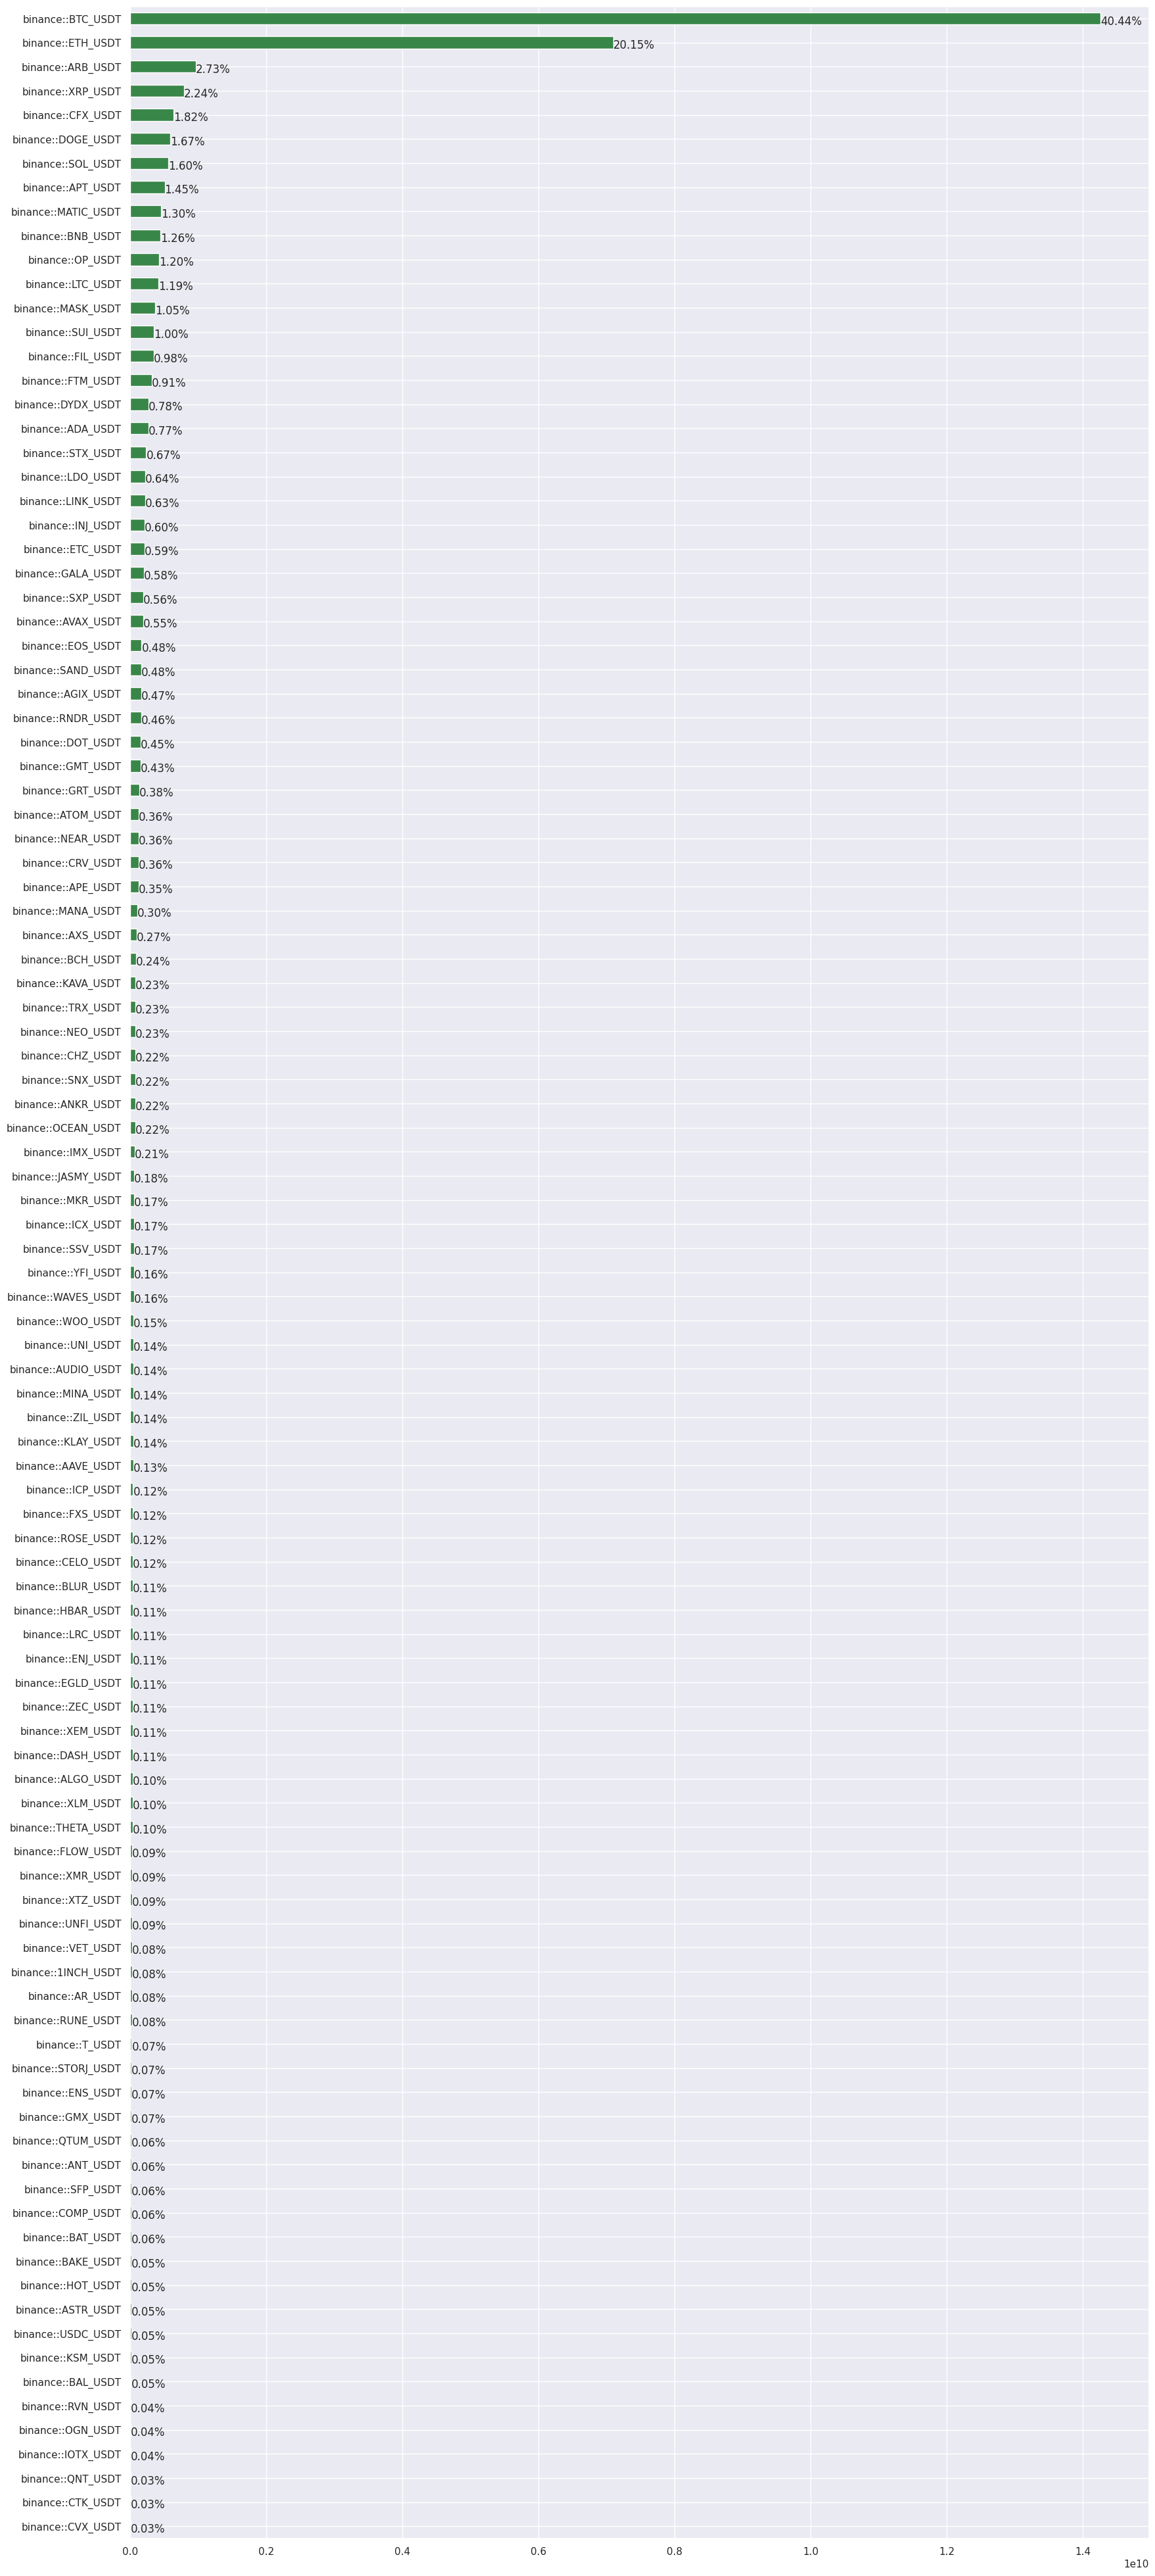

In [21]:
coplotti.plot_barplot(
    mdv_notional.sort_values(),
    orientation="horizontal",
    figsize=[20, 50],
)

In [22]:
# Exclude BTC and ETH.
mask = mdv_notional.index.isin(["binance::BTC_USDT", "binance::ETH_USDT"])
mdv_notional_no_btc_eth = mdv_notional[~mask]

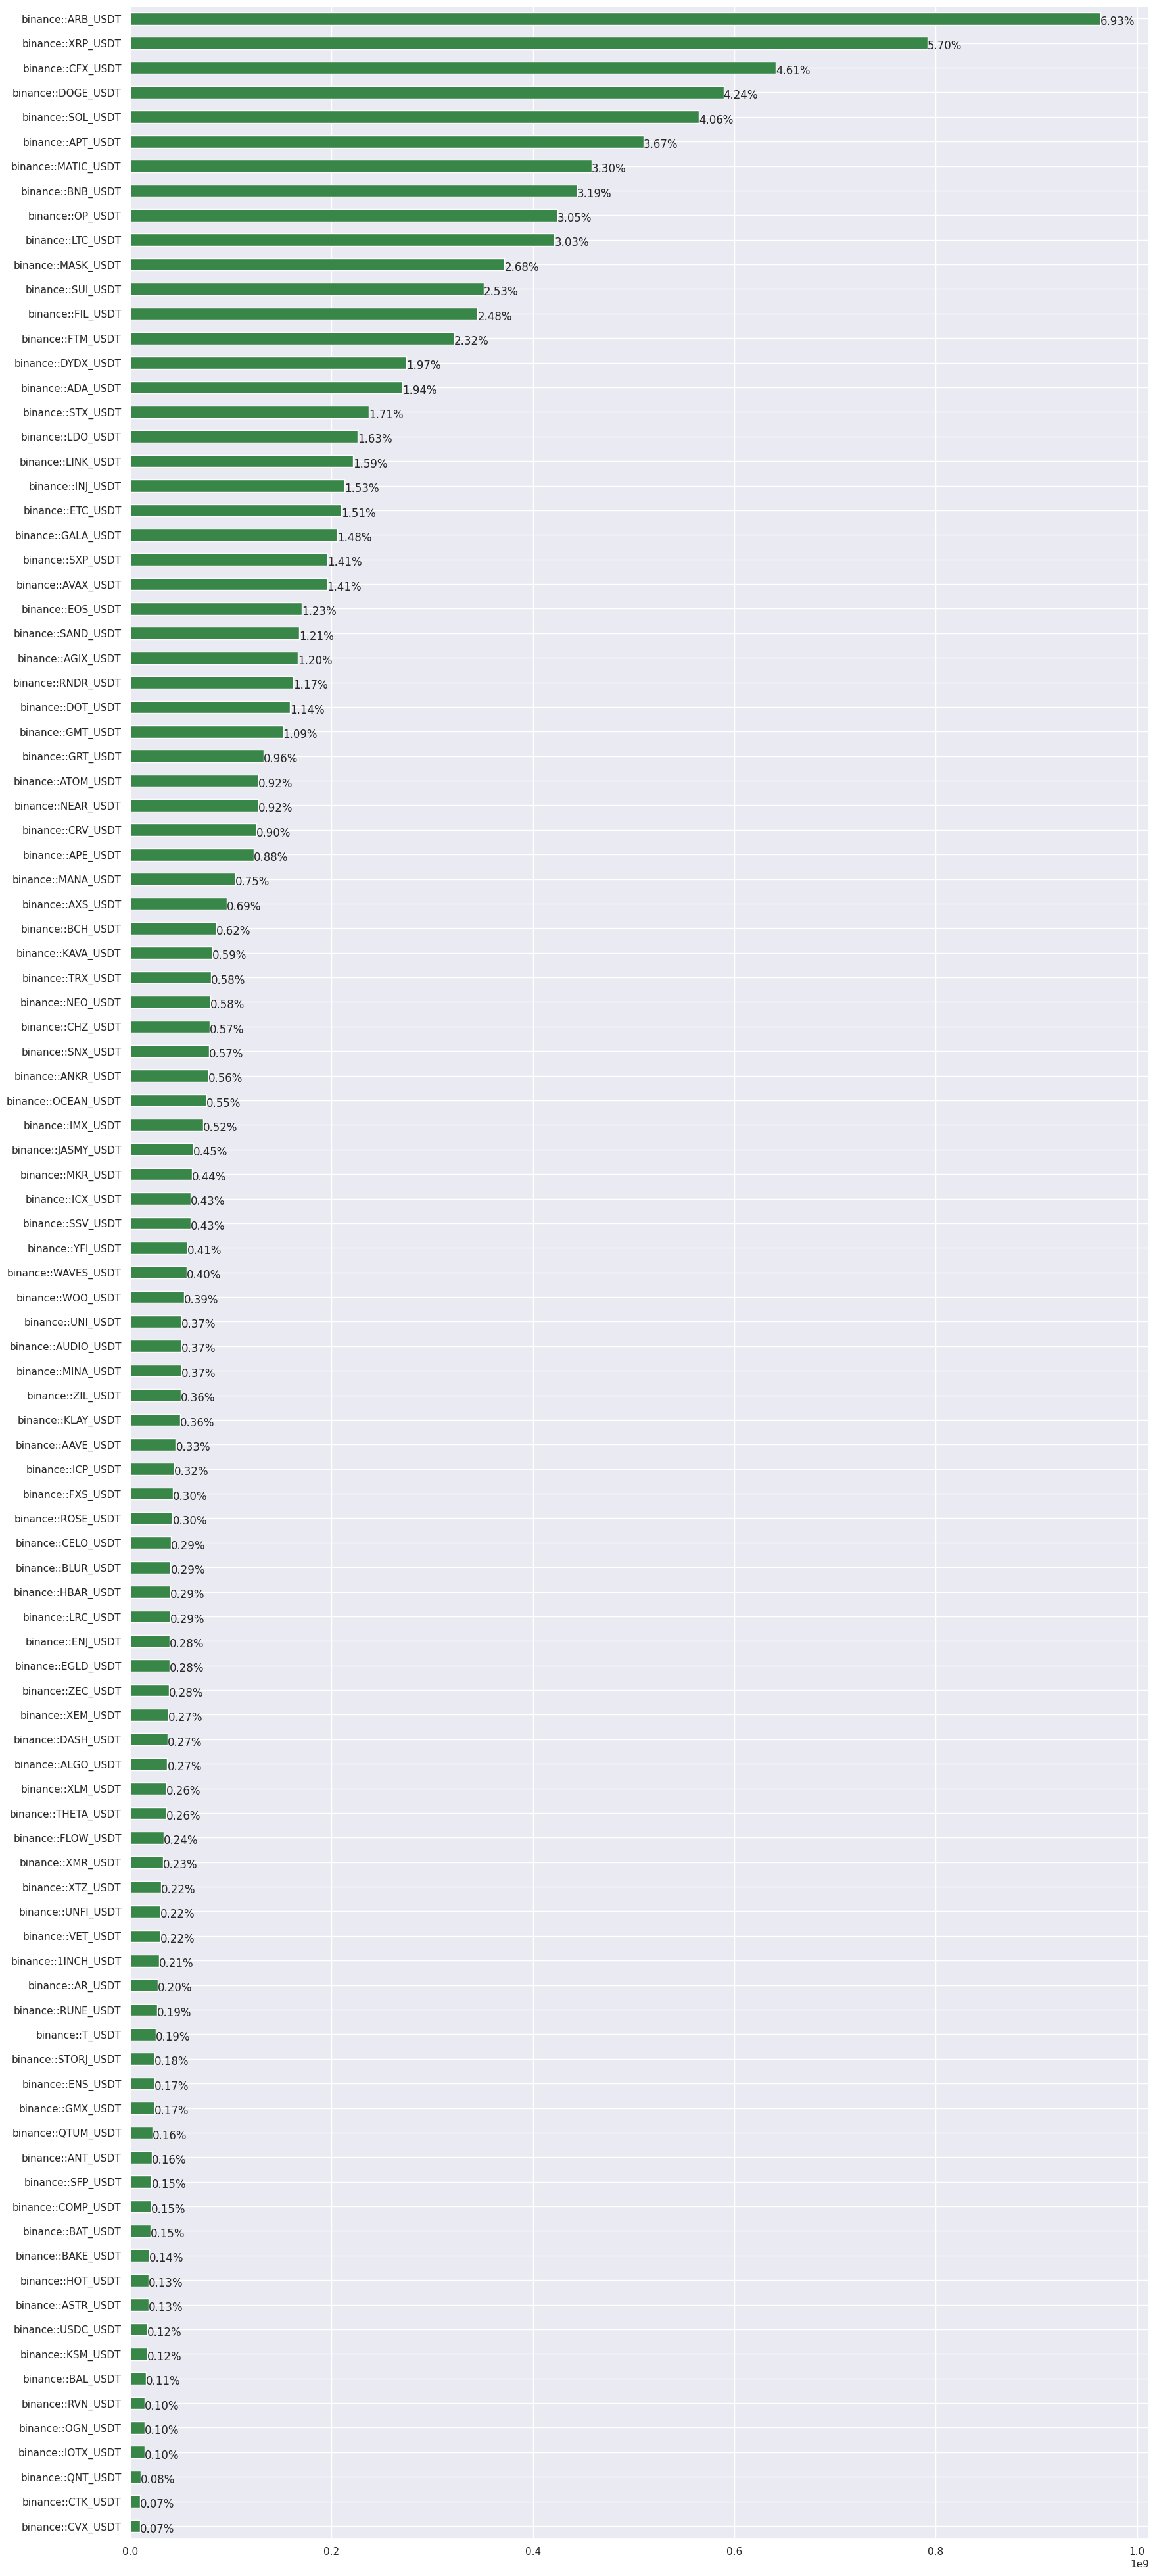

In [23]:
coplotti.plot_barplot(
    mdv_notional_no_btc_eth.sort_values(),
    orientation="horizontal",
    figsize=[20, 50],
)

In [24]:
volume_notional_as_pct = (
    mdv_notional_no_btc_eth * 100 / mdv_notional_no_btc_eth.sum()
)
volume_notional_as_pct = volume_notional_as_pct.sort_values(ascending=False)
volume_notional_as_pct

binance::ARB_USDT      6.933583
binance::XRP_USDT      5.696247
binance::CFX_USDT      4.613878
binance::DOGE_USDT     4.240428
binance::SOL_USDT      4.062737
binance::APT_USDT      3.666993
binance::MATIC_USDT    3.296850
binance::BNB_USDT      3.193697
binance::OP_USDT       3.053581
binance::LTC_USDT      3.031986
binance::MASK_USDT     2.675244
binance::SUI_USDT      2.528250
binance::FIL_USDT      2.482113
binance::FTM_USDT      2.316620
binance::DYDX_USDT     1.974403
binance::ADA_USDT      1.944589
binance::STX_USDT      1.707703
binance::LDO_USDT      1.626723
binance::LINK_USDT     1.594715
binance::INJ_USDT      1.533989
binance::ETC_USDT      1.509220
binance::GALA_USDT     1.480226
binance::SXP_USDT      1.411475
binance::AVAX_USDT     1.408157
binance::EOS_USDT      1.228280
binance::SAND_USDT     1.207795
binance::AGIX_USDT     1.200829
binance::RNDR_USDT     1.167482
binance::DOT_USDT      1.141970
binance::GMT_USDT      1.093190
binance::GRT_USDT      0.955555
binance: